In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import log as ln
from scipy.stats import norm
from scipy.stats import gamma

## 1. Draw a contour of the target posterior distribution p(u,t|y)

In [2]:
y_data = np.array([1.64, 1.70, 1.72, 1.74, 1.82, 1.82, 1.82, 1.90, 2.08, 1.78, 1.86, 1.96, 1.96, 2.0,2.0])

n = len(y_data)
u = np.linspace(0, 4, 100)
t = np.linspace(0.01, 0.4, 100)
u0 = 0
a0 = 2
b0 = 60
k = 1/2

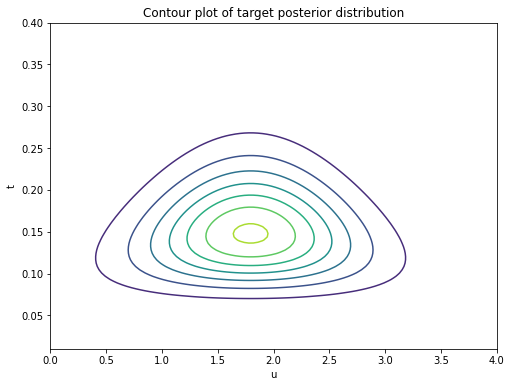

In [3]:
# Calculating target posterior density
def target_post(u, t):
    logpriormu = norm.logpdf(u, u0, np.sqrt(1/(k*t)))
    logpriortau = gamma.logpdf(t, a0, loc = 0, scale = 1/b0)
    logL = 0
    for i in range(n):
        logL += norm.logpdf(y_data[i], u, np.sqrt(1/t))
    return np.exp(logpriormu + logpriortau + logL)

# Setting mu, tau, target posterior density
U, T = np.meshgrid(u, t) # mu and tau
Z_target = target_post(U,T) # target posterior density

# Contour plot
fig, ax = plt.subplots(figsize=(8,6))
ax.contour(U, T, Z_target)
ax.set_xlabel('u')
ax.set_ylabel('t')
ax.set_title('Contour plot of target posterior distribution')

plt.show()

## 2. Derive the coordinate descent algorithm to find the optimal mean-field variational distribution q(u,t) and write a R/Python code to implement the algorithm.

In [4]:
def mean_field_vi(max_iter, a_1, b_1):
    
    max_iter = max_iter
    tolerance = 1e-15
    converged = False
    a_1 = a_1
    b_1 = b_1 # initial b value
    s_list = [a_1]
    b_list = [b_1]

    for i in range(max_iter):

        m = (n * np.mean(y_data) + k*u0) / (n + k)
        a = (n+1)/2 + a0

        s = 1 / ((a / b_1)*(n+k)) 
        b = 1/2 *(y_data.T @ y_data - 2* (y_data*m).T @ np.ones(len(y_data)) + n*(s + (m**2)) + k*(s + (m**2)) - 2*k*u0*m + k*(u0**2)) + b0

        # list update
        s_list.append(s)
        b_list.append(b)

        # Stopping rule
        if abs(s_list[i+1] - s_list[i]) < tolerance and abs(b_list[i+1] - b_list[i]) < tolerance :
            converged = True
            break

        # update the b for the next iteration
        b_1 = b

    if converged:
        return m, s, a, b

## 3. After initializing the parameters of q2(t) as a = 4, b = 1, run one iteration of a variational density estimation. Then draw a contour of the current iterate q(u,t)

m = 1.7935483870967746, s = 0.016129032258064516, a = 10.0, b = 61.06987741935485


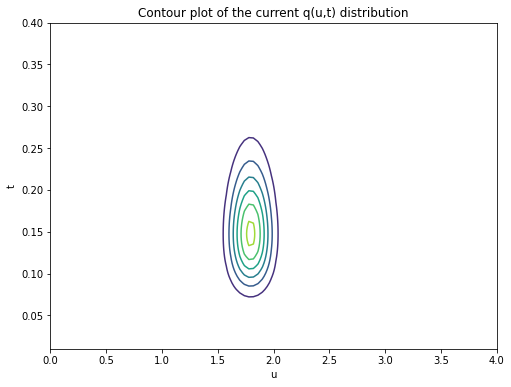

In [95]:
# Initialization of the parameters a and b
a_1 = 4
b_1 = 1

# One iteration of a variational density estimation
m = (n * np.mean(y_data) + k*u0) / (n + k)
a = (n+1)/2 + a0
s = 1 / ((a_1 / b_1)*(n+k)) 
b = 1/2 *(y_data.T @ y_data - 2* (y_data*m).T @ np.ones(len(y_data)) + n*(s + (m**2)) + k*(s + (m**2)) - 2*k*u0*m + k*(u0**2)) + b0

print("m = {}, s = {}, a = {}, b = {}".format(m, s, a, b)) 

U, T = np.meshgrid(u, t)

# Z value of optimal q function
def Z(m, s, a, b):
    q_u = norm.pdf(U, loc = m, scale = np.sqrt(s))
    q_t = gamma.pdf(T, a, loc = 0, scale  = 1/ b)
    Z = []

    for x, y in zip(q_u, q_t):
        product = x * y
        Z.append(product)

    Z = np.array(Z).reshape(U.shape)
    return Z

# Contour plot
fig, ax = plt.subplots(figsize=(8,6))
ax.contour(U, T, Z(m,s,a,b))
ax.set_xlabel('u')
ax.set_ylabel('t')
ax.set_title('Contour plot of the current q(u,t) distribution')

plt.show()

## 4. Iterate the variational inference until ELBO converges

m = 1.7935483870967746, s = 0.4138871132044472, a = 10.0, b = 64.15250254668932


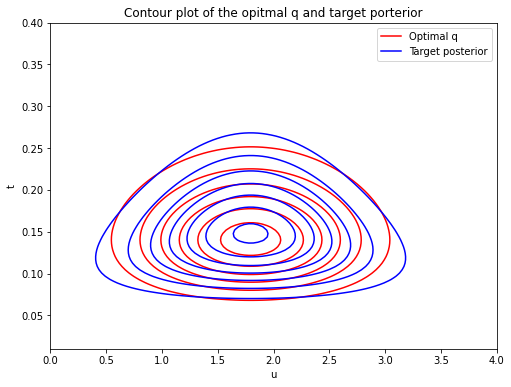

In [5]:
# Iteration until Convergence

m, s, a, b = mean_field_vi(100, 4, 1)
print("m = {}, s = {}, a = {}, b = {}".format(m, s, a, b))

U, T = np.meshgrid(u, t)

# Z value of optimal q function
def Z(m, s, a, b):
    q_u = norm.pdf(U, loc = m, scale = np.sqrt(s))
    q_t = gamma.pdf(T, a, loc = 0, scale  = 1/ b)
    Z = []

    for x, y in zip(q_u, q_t):
        product = x * y
        Z.append(product)

    Z = np.array(Z).reshape(U.shape)
    return Z
Z = Z(m,s,a,b)

# Z value of the target posterior distribution
Z_target = target_post(U,T)


# Superimpose the contour plots of optimal q and target posterior
fig, ax = plt.subplots(figsize = (8,6))
q = ax.contour(U, T, Z, colors = 'red')
p = ax.contour(U, T, Z_target, colors = 'blue')

proxy_artists = [plt.Line2D([0], [0], linestyle='-', color=q.collections[0].get_edgecolor()[0]),
                 plt.Line2D([0], [0], linestyle='-', color=p.collections[0].get_edgecolor()[0])]
labels = ['Optimal q', 'Target posterior']
plt.legend(proxy_artists, labels)

ax.set_xlabel('u')
ax.set_ylabel('t')
ax.set_title('Contour plot of the opitmal q and target porterior')
plt.show()